<a href="https://colab.research.google.com/github/HanhaodiZhang/HATE/blob/main/offenseval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset.git
!pip install -qq transformers

Cloning into 'Ethos-Hate-Speech-Dataset'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 93 (delta 41), reused 52 (delta 13), pack-reused 0
Unpacking objects: 100% (93/93), done.
     |████████████████████████████████| 1.3MB 11.7MB/s 
     |████████████████████████████████| 2.9MB 41.0MB/s 
     |████████████████████████████████| 890kB 45.3MB/s 
     |████████████████████████████████| 1.1MB 39.4MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
df = pd.read_csv("olid-training.tsv", sep='\t', header=0, index_col='id')

In [ ]:
df.head()

,tweet,subtask_a,subtask_b,subtask_c
id,,,,
86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [ ]:
df.shape

(13240, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13240 entries, 86426 to 46552
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
 2   subtask_b  4400 non-null   object
 3   subtask_c  3876 non-null   object
dtypes: object(4)
memory usage: 517.2+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


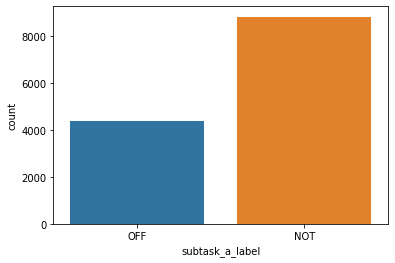

In [ ]:
sns.countplot(df.subtask_a)
plt.xlabel('subtask_a_label');

In [ ]:
def to_sentiment(label):
  label = str(label)
  if label == "OFF":
    return 1.0
  else:
    return 0.0

df['a_sentiment']=df.subtask_a.apply(to_sentiment)

In [ ]:
df.head()

,tweet,subtask_a,subtask_b,subtask_c,a_sentiment
id,,,,,
86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,1.0
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,1.0
16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0.0
62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,1.0
43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13240 entries, 86426 to 46552
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet        13240 non-null  object 
 1   subtask_a    13240 non-null  object 
 2   subtask_b    4400 non-null   object 
 3   subtask_c    3876 non-null   object 
 4   a_sentiment  13240 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [ ]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer

def clean_comment(text, stops=True, stemming=True):
  text = str(text)
  text = text.lower().split()
  text = " ".join(text)
  text = re.sub(r"@user", " ", text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"don't", "do not ", text)
  text = re.sub(r"aren't", "are not ", text)
  text = re.sub(r"isn't", "is not ", text)
  text = re.sub(r"%", " percent ", text)
  text = re.sub(r"that's", "that is ", text)
  text = re.sub(r"doesn't", "does not ", text)
  text = re.sub(r"he's", "he is ", text)
  text = re.sub(r"she's", "she is ", text)
  text = re.sub(r"it's", "it is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ! ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ^ ", text)
  text = re.sub(r"\+", " + ", text)
  text = re.sub(r"\-", " - ", text)
  text = re.sub(r"\=", " = ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
  text = text.lower().split()
  text = [w for w in text if len(w) >= 2]
  if stemming:
    englishStemmer = SnowballStemmer("english")
    text = [englishStemmer.stem(w) for w in text]
  if stops:
    text = [w for w in text if w not in stopwords.words('english')]
  text = " ".join(text)
  return text

In [ ]:
df['comment']=df.tweet.apply(clean_comment)

In [ ]:
df.head()

,tweet,subtask_a,subtask_b,subtask_c,a_sentiment,comment
id,,,,,,
86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,1.0,ask nativ american take
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,1.0,go home drunk maga trump2020 url
16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0.0,amazon investig chines employe sell intern dat...
62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,1.0,someon taken piec shit volcano
43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0.0,obama want liber amp; illeg move red state


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:

class GPReviewDataset(Dataset):
  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)

  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.comment.to_numpy(),
    targets=df.a_sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
token_lens = []
for txt in df.comment:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


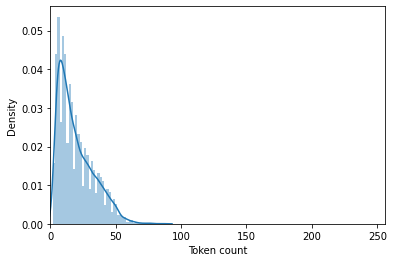

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:

MAX_LEN = 90
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)    
    self.out = nn.Linear(32, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = F.relu(self.fc1(pooled_output))
    output = F.relu(self.fc2(output))
    output = F.relu(self.fc3(output))
    output = self.out(output)
    return torch.sigmoid(output)

In [ ]:
model = SentimentClassifier(1)
model = model.to(device)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    optimizer.zero_grad()
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    # print(targets)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    outputs = outputs.squeeze(1)

    preds = torch.round(outputs)

    loss = loss_fn(outputs, targets.float())
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from sklearn.metrics import f1_score
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  
  f1_total = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      outputs = outputs.squeeze(1)
      preds = torch.round(outputs)

      loss = loss_fn(outputs,targets.float())
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())



      f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), average='macro')
      f1_total += f1
  return correct_predictions.double() / n_examples, f1_total/len(data_loader), np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_f1, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} f1 {val_f1} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 2/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 3/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 4/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 5/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 6/10
----------
Train loss 0.6931471824645996 accuracy 0.670359180933199
Val   loss 0.6931471824645996 f1 0.39496032749044746 accuracy 0.6525679758308157

Epoch 7/10
----------
Train loss 0